In [19]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch

from transformers import ViTFeatureExtractor, ViTModel, ViTForImageClassification, ViTConfig


from ipynb.fs.full.vit_notebook import ViTfinetune

In [8]:
def load_model(checkpoint_file_path=None):
    model = ViTfinetune.load_from_checkpoint(checkpoint_file_path)
    #model.load_from_checkpoint(checkpoint_file_path)
    return model
    pass

In [9]:
def inference(model, image: np.array, transformer_feature_extractor, class_list):
    result = []
    model_input = transformer_feature_extractor(image, return_tensors='pt')['pixel_values']
    log_prob, att = model.vit_model(model_input)
    prob=torch.sigmoid(log_prob)
    for each_img_in_batch in range(prob.shape[0]):
        tmp_prob = prob[each_img_in_batch].tolist()
        tmp_out_dict = dict(zip(class_list, tmp_prob))
        result.append(tmp_out_dict)
    return result,log_prob, att
        
        
    
    
    pass
    

In [24]:


image_path = "/abhishek/anish/fnS_images/Spark&Fire/Fun8.jpg"
img = cv2.imread(image_path)
ip = img #[img, img, img]
feature_extractor  = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = load_model("model/model-epoch=02-val_loss=0.37.ckpt")

In [28]:
result, logits, att_mat  = inference(model, ip, feature_extractor, ['fire','smoke', 'spark'])
im = Image.open(image_path)

In [26]:
def get_att_mask(image_path, logits, att_mat):
    im = Image.open(image_path)

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask**2 * im).astype("uint8")
    return im, result, mask


In [29]:
im, result, mask = get_att_mask(image_path, logits, att_mat)

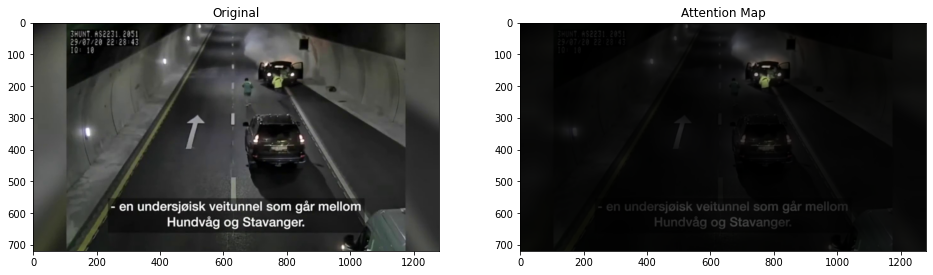

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)




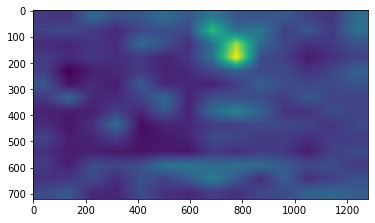

In [32]:
plt.imshow(mask)